In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [31]:
train_data = datasets.MNIST(
    root="data", train=True, transform=ToTensor(), download=True
)

test_data = datasets.MNIST(
    root="data", train=False, transform=ToTensor(), download=True
)

In [9]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [10]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [11]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [32]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}


In [13]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x762c34c9f380>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x762d4837e490>}

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}"
            )


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(
        f"\nTest set: Average Loss: {test_loss:.4f}, Accuracy: {correct / len(loaders['test'].dataset):.4f} "
        f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n"
    )


In [35]:
for epoch in range(1, 11):
    train(epoch)
    test()

/tmp/ipykernel_4068/4166115521.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0 / 60000 (0%)]	Loss: 2.301594
Train Epoch: 1 [2000 / 60000 (3%)]	Loss: 2.283265
Train Epoch: 1 [4000 / 60000 (7%)]	Loss: 2.206589
Train Epoch: 1 [6000 / 60000 (10%)]	Loss: 2.026017
Train Epoch: 1 [8000 / 60000 (13%)]	Loss: 1.967116
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 1.877508
Train Epoch: 1 [12000 / 60000 (20%)]	Loss: 1.867585
Train Epoch: 1 [14000 / 60000 (23%)]	Loss: 1.799707
Train Epoch: 1 [16000 / 60000 (27%)]	Loss: 1.767324
Train Epoch: 1 [18000 / 60000 (30%)]	Loss: 1.780973
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 1.726633
Train Epoch: 1 [22000 / 60000 (37%)]	Loss: 1.695183
Train Epoch: 1 [24000 / 60000 (40%)]	Loss: 1.808055
Train Epoch: 1 [26000 / 60000 (43%)]	Loss: 1.666604
Train Epoch: 1 [28000 / 60000 (47%)]	Loss: 1.735069
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 1.728507
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 1.638429
Train Epoch: 1 [34000 / 60000 (57%)]	Loss: 1.726622
Train Epoch: 1 [36000 / 60000 (60%)]	Loss: 1.635756
Train Epoch: 1 [38000 /

In [25]:
device

device(type='cpu')

Prediction: 2


/tmp/ipykernel_4068/4166115521.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


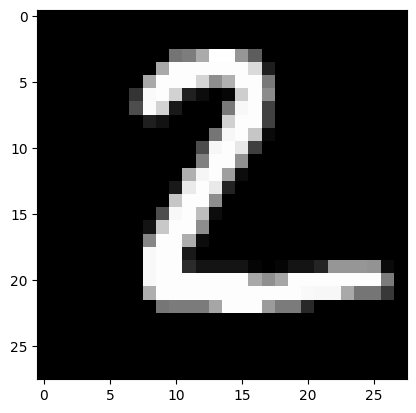

In [36]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[1]  

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()


# Resources

1. https://www.youtube.com/watch?v=vBlO87ZAiiw. NeuralNine. PyTorch Project: Handwritten Digit Recognition